In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc

matplotlib.rcParams['font.family'] = 'Liberation Sans'

df_all = pd.read_csv('paper-figure_celllist.csv')
print(df_all.shape)
df_all.head()

(318, 14)


,DataNumber,Class,Squ.epi,Leu,Debris,Para.Squ,Squ.meta,Para.Clust,Glan,LSIL,Age,HPV,HSIL,Adenocarcinoma
0,s001-d01-20240425r02-0069-20240426101009,ASC-US,84828,24297,19691,1251,945,145,100,62.0,57,-,NaN,NaN
1,s001-d01-20240425r02-0068-20240426095428,ASC-US,62235,56269,22859,451,318,281,92,11.0,31,+,8.0,NaN
2,s001-d01-20240425r02-0067-20240426093946,ASC-US,80253,7667,121918,248,234,12,72,9.0,49,+,1.0,NaN
3,s001-d01-20240425r02-0066-20240426092415,ASC-US,1234,1849,4776,700,1270,965,516,1.0,60,-,1.0,NaN
4,s001-d01-20240425r02-0064-20240426090218,ASC-US,68112,42277,114637,228,131,182,152,29.0,24,+,7.0,NaN


In [2]:
class_to_color = {
    'Para.Squ' : plt.cm.tab20(4),
    'Para.Clust' : plt.cm.tab20(5),
    'Squ.epi' : plt.cm.tab20(0),
    'Squ.meta' : plt.cm.tab20(16),
    'Glan' : plt.cm.tab20(8),
    'LSIL' : plt.cm.tab20(2),
    'HSIL' : plt.cm.tab20(6),
    'Adenocarcinoma' : plt.cm.tab20(12),
    'Leu': plt.cm.tab20(18),
    'Debris': plt.cm.tab20(14),
}

# Stack order for the bar plot
custom_stack_order = ['Squ.epi', 'Squ.meta', 'Para.Squ', 'Para.Clust', 'Glan', 'Leu','Debris', 'LSIL', 'HSIL', 'Adenocarcinoma']
legend_stack_order = ['Leu', 'Squ.epi', 'Para.Squ', 'Squ.meta', 'Glan', 'Para.Clust', 'LSIL', 'HSIL', 'Adenocarcinoma', 'Debris']
legend_labels= ['Leukocyte', 'Superficial/intermediate cell', 'Parabasal cell', 'Squamous metaplasia', 'Glandular cell', 'Miscellaneous cell cluster', 'LSIL', 'HSIL', 'Adenocarcinoma', 'Irrelevant object']

# Custom class order for the classification
custom_class_order = ['NILM', 'ASC-US', 'LSIL', 'ASC-H', 'HSIL', 'SCC']

def dfprep(df, class_columns=custom_stack_order, class_order=custom_class_order):

    df.loc[:,class_columns] = df.loc[:,class_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    df.loc[:,'Class_Total'] = df.loc[:,class_columns].sum(axis=1) 
    df['Class2'] = pd.Categorical(df.loc[:,'Class'], categories=class_order, ordered=True)
    df_sorted = df.sort_values(['Class2', 'Class_Total'], ascending=[True, False]) 
    x_labels = [f"S{i:03d}" for i in df_sorted.index]
    return df_sorted, x_labels    

def configure_plot(ax, title, x_label, y_label, legend_stack_order=legend_stack_order, legend_labels=legend_labels):
    ax.set_xlabel(x_label, fontsize=48)
    ax.set_ylabel(y_label, fontsize=48)
    ax.set_title(title, fontsize=48)

    handles, labels = ax.get_legend_handles_labels()
    label_map = dict(zip(legend_stack_order, legend_labels))
    reordered_handles = [handles[labels.index(label)] for label in legend_stack_order]
    reordered_labels = [label_map[label] for label in legend_stack_order]
    ax.legend(reordered_handles, reordered_labels, title='',
              bbox_to_anchor=(1, 0.5), loc='center left',
              frameon=False, fontsize=32, title_fontsize=36)

    ax.tick_params(axis='y', labelsize=36)
    plt.xticks(rotation=90)
    ax.margins(x=0)
    plt.tight_layout()
    plt.show()



def draw_hist_totalcount(df, stack_order=custom_stack_order, legend_stack_order=legend_stack_order, legend_labels=legend_labels):

    df_sorted, x_labels = dfprep(df, stack_order)
    fig, ax = plt.subplots(figsize=(40, 8))
    bottom_values = np.zeros(len(df_sorted))
    for col in stack_order:
        ax.bar(x_labels, df_sorted[col], label=col, color=class_to_color[col], bottom=bottom_values)
        bottom_values += df_sorted[col] 
        
        ax.set_ylim(bottom=100, top=1000000)

    ax.set_yscale('log')
    configure_plot(ax, '', 'Sample', 'Count', legend_stack_order, legend_labels)

    return fig, ax


def draw_hist_keycount(df, keys, title='', stack_order=custom_stack_order, legend_stack_order=legend_stack_order, legend_labels=legend_labels):

    df_sorted, x_labels = dfprep(df, stack_order)
    fig, ax = plt.subplots(figsize=(40, 8))

    bottom_values = np.zeros(len(df_sorted))
    for col in keys:
        ax.bar(x_labels, df_sorted[col], label=col, color=class_to_color[col], bottom=bottom_values)
        bottom_values += df_sorted[col]
        
    configure_plot(ax, '', 'Sample', 'Count', legend_stack_order=legend_stack_order, legend_labels=legend_labels)

    return fig, ax


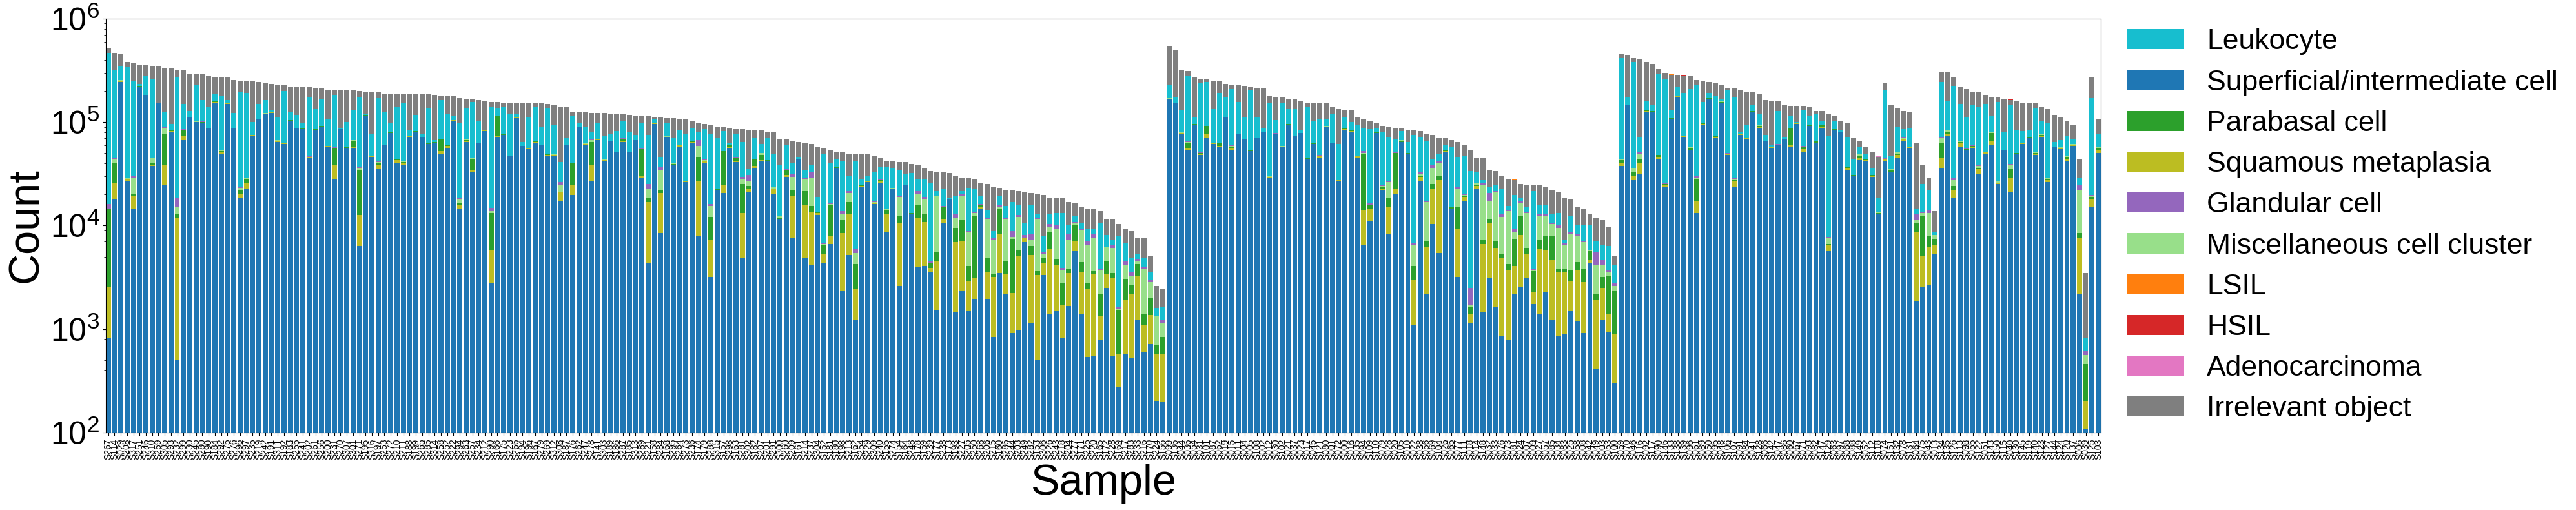

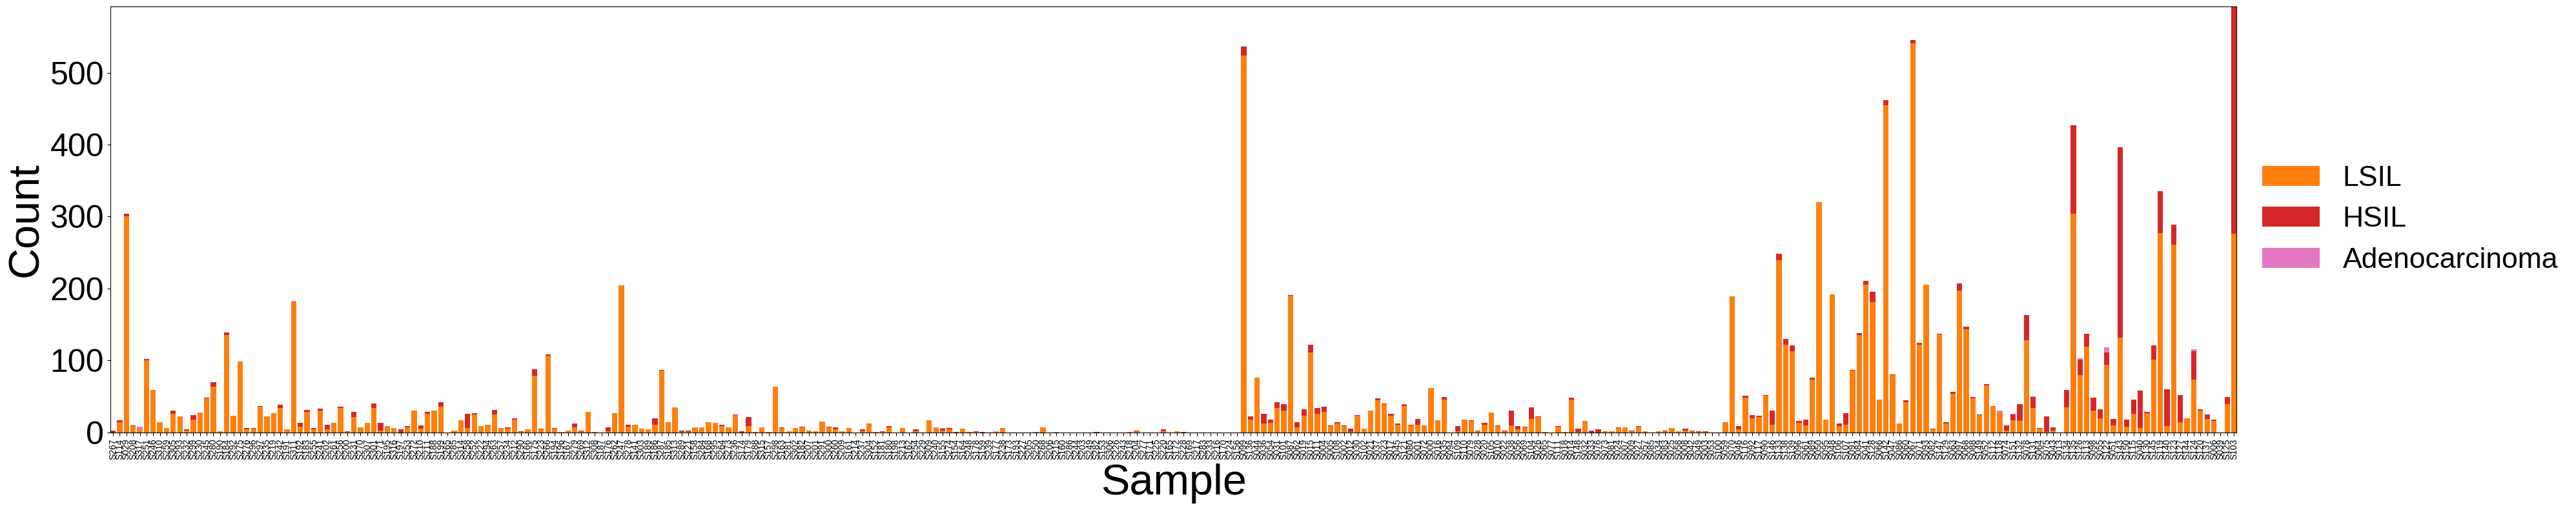

In [3]:
fig_dir = 'figs/313-31y41/'

fig, ax = draw_hist_totalcount(df_all)
fig.savefig(f'{fig_dir}/fig5a_all-slide-total-count.svg', bbox_inches='tight')

posilist = ['LSIL', 'HSIL', 'Adenocarcinoma']
fig, ax = draw_hist_keycount(df_all, ['LSIL', 'HSIL', 'Adenocarcinoma'], stack_order=custom_stack_order, legend_stack_order=posilist, legend_labels=posilist)
fig.savefig(f'{fig_dir}/fig5b_all-slide-positive-count.svg', bbox_inches='tight')


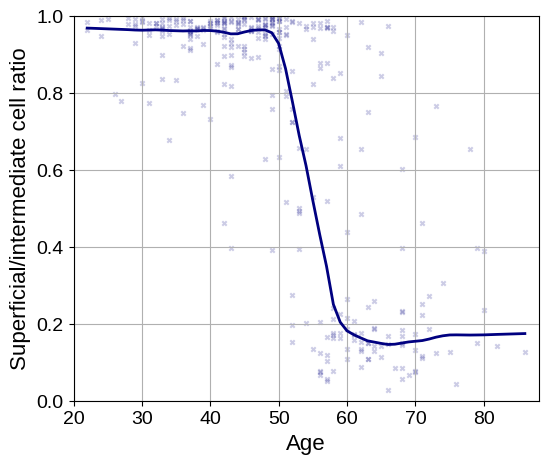

In [ ]:
# LOESS / LOWESS

epi_columns = ['Glan', 'Squ.epi', 'Squ.meta', 'Para.Squ', 'Para.Clust', 'LSIL', 'HSIL', 'Adenocarcinoma']
df = df_all
df['_epi_sum'] = df[epi_columns].sum(axis=1)
df['_target_ratio'] = df['Squ.epi'] / (df['_epi_sum'])

x_data = df['Age'].values
y_data = df['_target_ratio'].values

lowess = sm.nonparametric.lowess
smoothed = lowess(y_data, x_data, frac=0.2)

plt.figure(figsize=(6, 5))
plt.scatter(x_data, y_data, color='navy',  marker='x', s=10, alpha=0.2, label='Raw Data')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='navy', linewidth=2, label='LOWESS (frac=0.2)')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Superficial/intermediate cell ratio', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.xlim(20, 88)
plt.ylim(0, 1)
plt.margins(x=0, y=0)
plt.grid(True)
plt.savefig(f'{fig_dir}/fig5c_superficial-cell-ratio.svg', bbox_inches='tight')
plt.show()


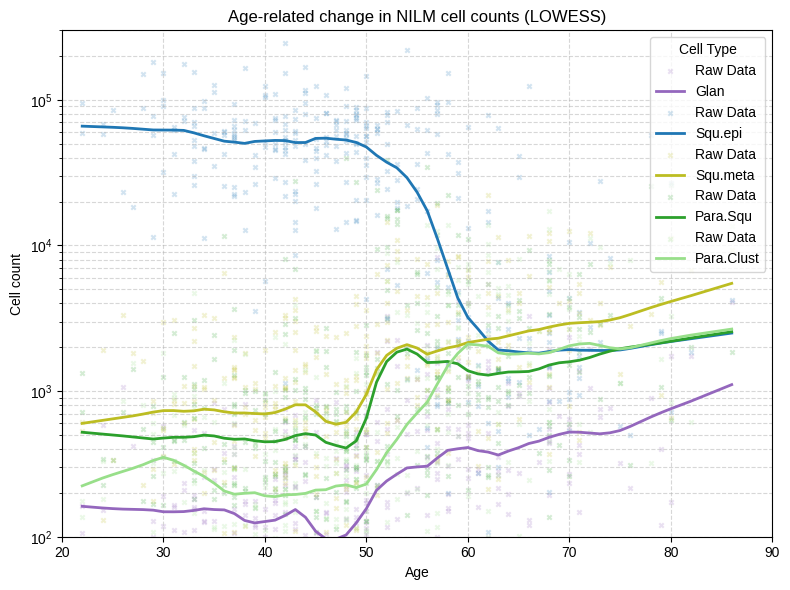

In [5]:
nilm_cells = ['Glan', 'Squ.epi', 'Squ.meta', 'Para.Squ', 'Para.Clust']

df = df_all.copy()

plt.figure(figsize=(8, 6))

for cell in nilm_cells:
    x_data = df['Age'].values
    y_data = df[cell].values

    valid_idx = y_data > 0
    x_valid = x_data[valid_idx]
    y_valid = y_data[valid_idx]
    y_log = np.log(y_valid)

    # LOWESS
    smoothed = sm.nonparametric.lowess(y_log, x_valid, frac=0.2)
    x_fit = smoothed[:, 0]
    y_fit = np.exp(smoothed[:, 1]) 
    
    col = class_to_color.get(cell, 'black')
    plt.scatter(x_data, y_data, color=col,  marker='x', s=10, alpha=0.2, label='Raw Data')
    plt.plot(x_fit, y_fit, color=col, linewidth=2, label=cell)

plt.yscale('log')
plt.xlim(20, 90)
plt.ylim(100, 300000)
plt.margins(x=0, y=0)
plt.xlabel('Age')
plt.ylabel('Cell count')
plt.title('Age-related change in NILM cell counts (LOWESS)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title='Cell Type')
plt.tight_layout()
plt.show()

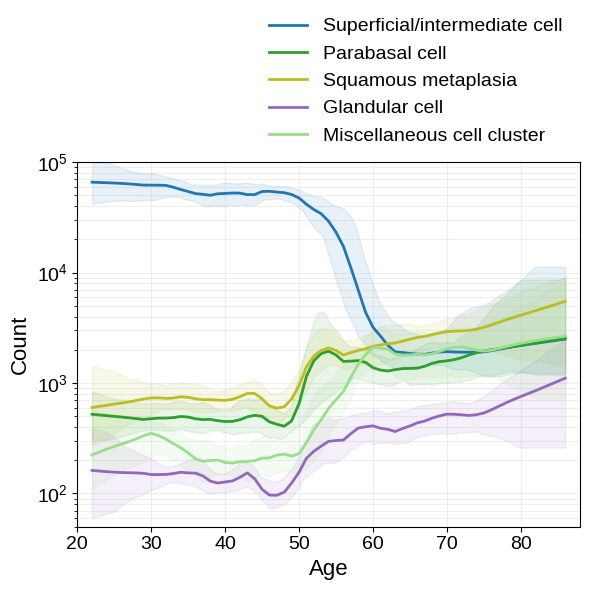

In [6]:
"""
# Age-related changes in the abundance of cytologically normal epithelial cell types in NILM samples.
LOWESS (Locally Weighted Scatterplot Smoothing) curves illustrate the age-associated trends in five types of cytologically normal epithelial cells 
from NILM (Negative for Intraepithelial Lesion or Malignancy) specimens: superficial/intermediate squamous cells, parabasal cells, squamous metaplastic 
cells, glandular cells, and miscellaneous cell clusters. The y-axis is shown on a logarithmic scale to accommodate differences in cell counts across types. 
Each line represents the smoothed estimate of cell count based on log-transformed data, and the shaded regions indicate 95% confidence intervals derived 
from bootstrap resampling (n = 100). This visualization reveals distinct age-related dynamics for each epithelial subpopulation, with substantial variation 
in both magnitude and trajectory across the lifespan.
"""


nilm_cells = ['Squ.epi', 'Para.Squ', 'Squ.meta', 'Glan', 'Para.Clust']
legend_labels= ['Superficial/intermediate cell', 'Parabasal cell', 'Squamous metaplasia', 'Glandular cell', 'Miscellaneous cell cluster']

df = df_all.copy()
x_eval = np.linspace(20, 90, 200)

plt.figure(figsize=(6, 6))

for cell, label in zip(nilm_cells, legend_labels):
    x_data = df['Age'].values
    y_data = df[cell].values

    # remove zero counts
    valid_idx = y_data > 0
    x_data = x_data[valid_idx]
    y_data = y_data[valid_idx]
    y_log = np.log(y_data)

    # restrict x-axis range for evaluation
    x_min = x_data.min()
    x_max = x_data.max()
    x_eval = np.linspace(x_min, x_max, 200)

    # original LOWESS curve (median line)
    lowess = sm.nonparametric.lowess
    smoothed = lowess(y_log, x_data, frac=0.2, return_sorted=True)
    x_smooth = smoothed[:, 0]
    y_smooth = np.exp(smoothed[:, 1])

    # Bootstrap for confidence intervals
    n_bootstrap = 100
    y_boot = np.zeros((n_bootstrap, len(x_eval)))

    for i in range(n_bootstrap):
        idx = np.random.choice(len(x_data), size=len(x_data), replace=True)
        x_sample = x_data[idx]
        y_sample = y_log[idx]
        smoothed_sample = lowess(y_sample, x_sample, frac=0.2, return_sorted=True)
        y_interp = np.interp(x_eval, smoothed_sample[:, 0], np.exp(smoothed_sample[:, 1]))
        y_boot[i, :] = y_interp

    y_lower = np.percentile(y_boot, 2.5, axis=0)
    y_upper = np.percentile(y_boot, 97.5, axis=0)

    # Plot
    col = class_to_color.get(cell, 'black')
    plt.plot(x_smooth, y_smooth, color=col, label=label, linewidth=2)
    plt.fill_between(x_eval, y_lower, y_upper, color=col, alpha=0.1)


plt.yscale('log')
plt.xlim(20, 88)
plt.ylim(50, 100000)
plt.margins(x=0, y=0)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True, which='both', linestyle='-', alpha=0.2)
plt.legend(loc='lower right', bbox_to_anchor=(1, 1), frameon=False, fontsize=14)
plt.tight_layout()
plt.savefig(f'{fig_dir}/fig5d_nilm-cell-counts.svg', bbox_inches='tight')
plt.show()


/tmp/ipykernel_76196/415408967.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


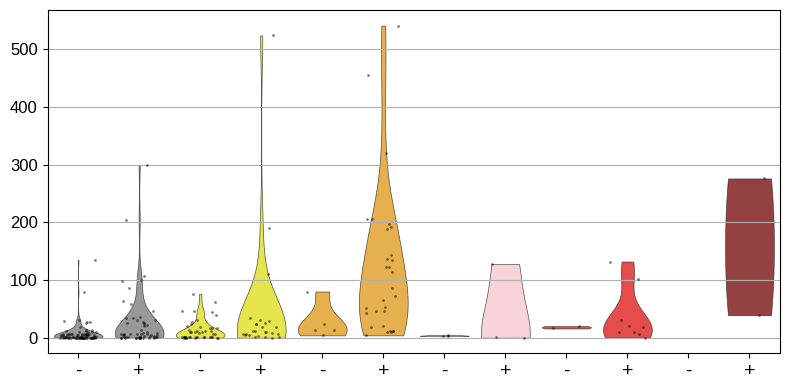

In [7]:
custom_class_order = ['NILM', 'ASC-US', 'LSIL', 'ASC-H', 'HSIL', 'SCC']

color_map = {
    'NILM': 'gray',
    'ASC-US': 'yellow',
    'LSIL': 'orange',
    'ASC-H': 'pink',
    'HSIL': 'red',
    'SCC': 'darkred'
}

df_all['Category'] = df_all['Class'] + ' / HPV ' + df_all['HPV']
df_all['LSIL_count'] = df_all['LSIL']

category_order = [f'{cls} / HPV {hpv}' for cls in custom_class_order for hpv in ['-', '+']]

category_palette = {
    f'{cls} / HPV {hpv}': color_map.get(cls, 'gray') for cls in custom_class_order for hpv in ['-', '+']
}
plt.figure(figsize=(8, 4))

# Violin plot
sns.violinplot(
    x='Category',
    y='LSIL_count',
    data=df_all,
    order=category_order,
    palette=category_palette,
    inner=None,   
    cut=0,        
    alpha=0.8, linewidth=0.5
)

# Strip plot
sns.stripplot(
    x='Category',
    y='LSIL_count',
    data=df_all,
    order=category_order,
    color='black',
    size=2,
    jitter=0.3,
    alpha=0.5
)

plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],labels=['-','+','-','+','-','+','-','+','-','+','-','+'])
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.grid(True, axis='y')
plt.savefig(f'{fig_dir}/fig5e_lsil-counts-by-class-hpv.svg', bbox_inches='tight')
plt.show()


/tmp/ipykernel_76196/2151816227.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


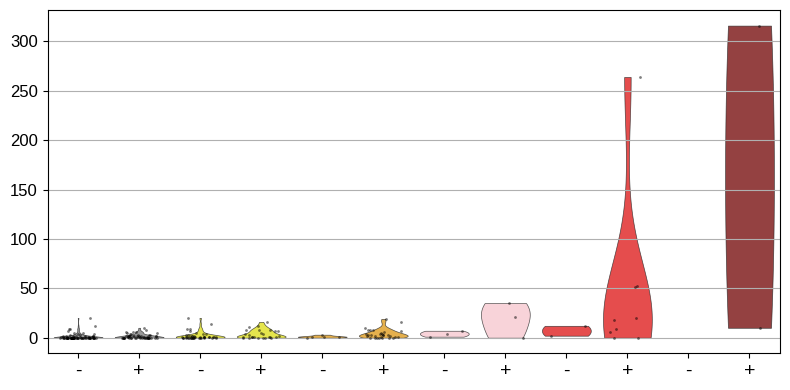

In [8]:
df_all['HSIL_count'] = df_all['HSIL']

category_order = [f'{cls} / HPV {hpv}' for cls in custom_class_order for hpv in ['-', '+']]

category_palette = {
    f'{cls} / HPV {hpv}': color_map.get(cls, 'gray') for cls in custom_class_order for hpv in ['-', '+']
}

plt.figure(figsize=(8, 4))

# violin plot
sns.violinplot(
    x='Category',
    y='HSIL_count',
    data=df_all,
    order=category_order,
    palette=category_palette,
    inner=None, 
    cut=0,
    alpha=0.8, linewidth=0.5
)

# strip plot
sns.stripplot(
    x='Category',
    y='HSIL_count',
    data=df_all,
    order=category_order,
    color='black',
    size=2,
    jitter=0.3,
    alpha=0.5
)

plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],labels=['-','+','-','+','-','+','-','+','-','+','-','+'])
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.grid(True, axis='y')
plt.savefig(f'{fig_dir}/fig5f_hsil-counts-by-class-hpv.svg', bbox_inches='tight')
plt.show()


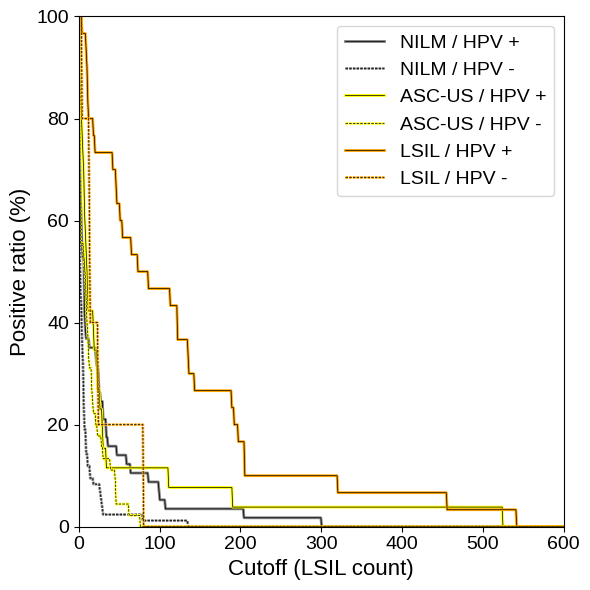

In [ ]:
"""
# Positive rate by LSIL count cutoff across cytological categories

Proportion of positive cases within each cytological category as a function of LSIL count cutoff values. 
The horizontal axis represents the cutoff threshold for LSIL-positive cells per specimen, while the vertical 
axis indicates the percentage of samples classified as positive (i.e., exceeding the cutoff) within each category. 
Categories were defined based on cytological diagnosis combined with HPV status (e.g., NILM / HPV+, ASC-US / HPV-). 
Solid lines denote HPV-positive cases, while dashed lines denote HPV-negative cases. Each line is color-coded 
based on the cytological class (e.g., gray for NILM, yellow for ASC-US, orange for LSIL), with black outlines 
added to improve visibility.
"""

import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects

df_all['HPV'] = df_all['HPV'].replace(['N/A', 'NA', '', 'na'], np.nan)
df_filtered = df_all[
    df_all['HPV'].notna() &
    df_all['Class'].isin(['LSIL', 'NILM', 'ASC-US'])
]

cutoffs = np.linspace(0, 600, 600)

plot_data = []
for category, group in df_filtered.groupby('Category'):
    total = len(group)
    if total == 0:
        continue
    ratios = [(sum(group['LSIL_count'] >= c) / total) * 100 for c in cutoffs]

    base_class = group['Class'].iloc[0]       # Ex.: ASC-US
    hpv_status = group['HPV'].iloc[0]         # Ex.: +/-

    line_style = '-' if hpv_status == '+' else '--'
    color = color_map.get(base_class, 'black')
    plot_data.append({
        'label': f"{base_class} / HPV {hpv_status}",
        'ratios': ratios,
        'color': color,
        'linestyle': line_style,
        'base_class': base_class,
        'hpv': hpv_status
    })

class_order = ['NILM', 'ASC-US', 'LSIL']
plot_data.sort(key=lambda x: (class_order.index(x['base_class']), x['hpv'] != '+'))

legend_lines = []

plt.figure(figsize=(6, 6))
for item in plot_data:
    plt.plot(
        cutoffs, item['ratios'],
        color='black', linestyle=item['linestyle'], linewidth=0.5,
        label=item['label'], zorder=2,
        path_effects=[path_effects.Stroke(linewidth=2, foreground=item['color']),
                      path_effects.Normal()]
    )

    legend_line = mlines.Line2D(
        [], [], color='black', linestyle=item['linestyle'], linewidth=0.5,
        label=item['label'],
        path_effects=[path_effects.Stroke(linewidth=2, foreground=item['color']),
                      path_effects.Normal()]
    )
    legend_lines.append(legend_line)

plt.xlabel("Cutoff (LSIL count)", fontsize=16)
plt.ylabel("Positive ratio (%)", fontsize=16)
plt.ylim(0, 100)
plt.margins(x=0)
plt.grid(False)
plt.tick_params(axis='both', labelsize=14)
plt.legend(handles=legend_lines, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=14)
plt.tight_layout()
plt.savefig(f'{fig_dir}/fig5g_positive-rate-by-lsil-count.svg', bbox_inches='tight')
plt.show()


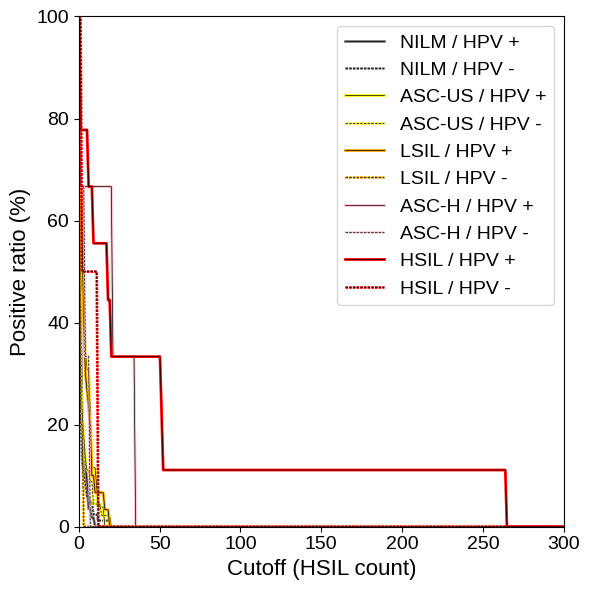

In [ ]:
"""
# Positive rate by HSIL count cutoff across cytological categories

Proportion of positive cases across cytological categories as a function of HSIL count cutoff values. 
The horizontal axis indicates the threshold for HSIL-positive cell counts, and the vertical axis 
represents the percentage of specimens exceeding that threshold within each category. 
HPV-positive and HPV-negative subgroups are represented by solid and dashed lines, respectively. 
Line colors and outlines correspond to the cytological classifications, enabling direct visual comparison of 
category-specific response trends to increasing HSIL counts.
"""

df_all['HPV'] = df_all['HPV'].replace(['N/A', 'NA', '', 'na'], np.nan)
df_filtered = df_all[
    df_all['HPV'].notna() &
    df_all['Class'].isin(['HSIL', 'LSIL', 'NILM', 'ASC-US', 'ASC-H'])
]

cutoffs = np.linspace(0, 300, 300)

plot_data = []
for category, group in df_filtered.groupby('Category'):
    total = len(group)
    if total == 0:
        continue
    ratios = [(sum(group['HSIL_count'] >= c) / total) * 100 for c in cutoffs]

    base_class = group['Class'].iloc[0]       # Ex.: ASC-US
    hpv_status = group['HPV'].iloc[0]         # Ex.: +/-

    line_style = '-' if hpv_status == '+' else '--'
    color = color_map.get(base_class, 'black')
    plot_data.append({
        'label': f"{base_class} / HPV {hpv_status}",
        'ratios': ratios,
        'color': color,
        'linestyle': line_style,
        'base_class': base_class,
        'hpv': hpv_status
    })

class_order = ['NILM', 'ASC-US', 'LSIL', 'ASC-H', 'HSIL']
plot_data.sort(key=lambda x: (class_order.index(x['base_class']), x['hpv'] != '+')) 

legend_lines = []

plt.figure(figsize=(6, 6))
for item in plot_data:
    plt.plot(
        cutoffs, item['ratios'],
        color='black', linestyle=item['linestyle'], linewidth=0.5,
        label=item['label'], zorder=2,
        path_effects=[path_effects.Stroke(linewidth=2, foreground=item['color']),
                      path_effects.Normal()]
    )

    legend_line = mlines.Line2D(
        [], [], color='black', linestyle=item['linestyle'], linewidth=0.5,
        label=item['label'],
        path_effects=[path_effects.Stroke(linewidth=2, foreground=item['color']),
                      path_effects.Normal()]
    )
    legend_lines.append(legend_line)

plt.xlabel("Cutoff (HSIL count)", fontsize=16)
plt.ylabel("Positive ratio (%)", fontsize=16)
plt.ylim(0, 100)
plt.margins(x=0)
plt.grid(False)
plt.tick_params(axis='both', labelsize=14)
plt.legend(handles=legend_lines, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=14)
plt.tight_layout()
plt.savefig(f'{fig_dir}/fig5h_positive-rate-by-hsil-count.svg', bbox_inches='tight')
plt.show()


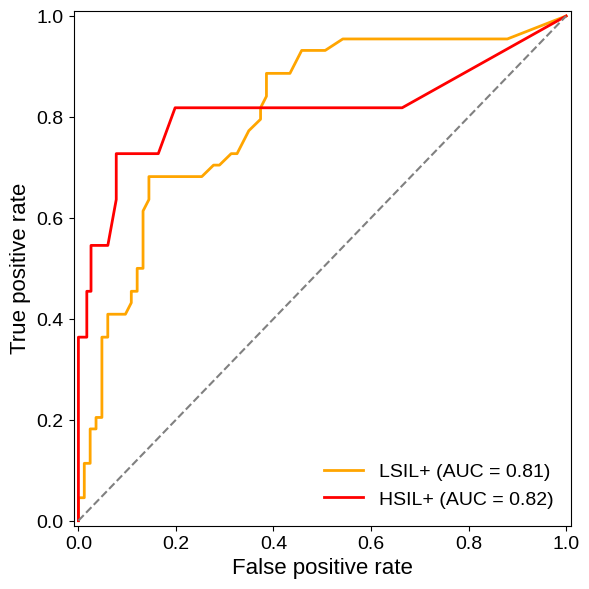

In [ ]:
"""
# ROC curves for detecting cytological abnormalities using LSIL and HSIL cell counts

Receiver Operating Characteristic (ROC) curves illustrating the diagnostic performance of LSIL and HSIL cell count-based indices. 
The orange line shows the performance of a combined LSIL + HSIL count metric for detecting low-grade or higher abnormalities 
(LSIL, ASC-H, HSIL, or SCC) among HPV-positive specimens. The red line represents the performance of HSIL count alone for 
detecting high-grade abnormalities (HSIL or SCC). The area under the curve (AUC) is shown for each model. 
These results demonstrate the relative effectiveness of cytological metrics in stratifying disease severity among HPV-positive cases.
"""

df_pos = df_all[df_all['HPV'] == '+'].copy()

# ---------- LSIL+ ----------
df_pos['label_lsil'] = df_pos['Class'].isin(['LSIL', 'ASC-H', 'HSIL', 'SCC']).astype(int)
df_pos['score_lsil'] = df_pos['LSIL_count'] + df_pos['HSIL_count']
fpr_lsil, tpr_lsil, _ = roc_curve(df_pos['label_lsil'], df_pos['score_lsil'])
auc_lsil = auc(fpr_lsil, tpr_lsil)

# ---------- HSIL+ ----------
df_pos['label_hsil'] = df_pos['Class'].isin(['HSIL', 'SCC']).astype(int)
df_pos['score_hsil'] = df_pos['HSIL_count']
fpr_hsil, tpr_hsil, _ = roc_curve(df_pos['label_hsil'], df_pos['score_hsil'])
auc_hsil = auc(fpr_hsil, tpr_hsil)

# ---------- Plot ----------
plt.figure(figsize=(6, 6))

# LSIL+: Orange
plt.plot(fpr_lsil, tpr_lsil, color='orange', lw=2,
         label=f'LSIL+ (AUC = {auc_lsil:.2f})')

# HSIL+: Red
plt.plot(fpr_hsil, tpr_hsil, color='red', lw=2,
         label=f'HSIL+ (AUC = {auc_hsil:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel("False positive rate", fontsize=16)
plt.ylabel("True positive rate", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.margins(x=0.01, y=0.01)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.grid(False)
plt.tight_layout()
plt.savefig(f'{fig_dir}/fig5i_roc-lsil-hsil.svg', bbox_inches='tight')
plt.show()
